In [ ]:
#| hide
# skip
! [ -e /content ] && pip install -Uqq model_inspector nbdev
# For colab. Restart the runtime after running this cell!

In [ ]:
#| default_exp inspect.linear_model

# Linear Model

> Inspector functionality for any model that inherits from `LinearModel` or `LinearClassifierMixin` (and thus has an intercept and coefficients)

In [ ]:
#| export
from typing import Iterable, Sequence, Union

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import waterfall_chart
from IPython.display import HTML
from model_inspector.delegate import delegates
from model_inspector.inspect.classifier import _BinInspector, _MultiInspector
from model_inspector.inspect.regressor import _RegInspector
from sklearn.base import clone

In [ ]:
#| hide
#| export
# Meant to be colorblind-friendly
COLORS = {"blue": "#377eb8", "orange": "#ff7f00", "green": "#4daf4a", "pink": "#f781bf"}

In [ ]:
#| export
class _LinInspectorMixin:
    """Abstract mixin class for linear model inspectors"""

    def show_model(*args, **kwargs):
        raise NotImplementedError()

    def plot_coefs_vs_hparam(*args, **kwargs):
        raise NotImplementedError()

    def plot_waterfall(*args, **kwargs):
        raise NotImplementedError()

    def _generate_model_html(
        self,
        intercept: float,
        coefs: Sequence[float],
        target_name: str,
        intercept_formatter: str = ".2f",
        coef_formatter: str = ".2f",
    ):
        if len(coefs) != len(self.X.columns):
            raise ValueError("len(coefs) != len(feature_cols)")
        model_string = f"""
            <span style='color:{COLORS["pink"]}'>{target_name}</span>
            = <span style='color:{COLORS["orange"]}'>{intercept:{intercept_formatter}}</span>
        """  # noqa: E501
        for coef, feature_col in zip(coefs, self.X.columns):
            model_string += f"""
                <span style='color:{COLORS["green"]}'>{"+" if coef >= 0 else "-"} {abs(coef):{coef_formatter}}</span>
                * <span style='color:{COLORS["blue"]}'>{feature_col}</span>
            """  # noqa: E501
        return model_string

    def _plot_waterfall(
        self,
        item: Union[pd.Series, np.array],
        intercept: float,
        coefs: Sequence[float],
        y_lab: str,
        bar_num_formatter: str = ".1f",
        tick_num_formatter: str = ".2f",
        sorted_value: bool = True,
        threshold: float = 0.01,
        blue_color=COLORS["blue"],
        green_color=COLORS["green"],
        red_color=COLORS["orange"],
        rotation_value: int = 270,
        **waterfall_kwargs,
    ):
        index = ["int"] + [
            f"{name}: {val:{tick_num_formatter}}"
            for name, val in zip(self.X.columns, item)
        ]
        vals = [intercept] + list(np.array(coefs) * item)
        waterfall_chart.plot(
            index=index,
            data=vals,
            x_lab="Feature name and value",
            y_lab=y_lab,
            formatting=f"{{:,{bar_num_formatter}}}",
            net_label=self.y.name,
            sorted_value=sorted_value,
            threshold=threshold,
            blue_color=blue_color,
            green_color=green_color,
            red_color=red_color,
            rotation_value=rotation_value,
            **waterfall_kwargs,
        )
        return plt.gca()

## Linear Regression

In [ ]:
#| export
class _LinRegInspector(_RegInspector, _LinInspectorMixin):
    """Linear regression model inspector"""

    def show_model(
        self,
        intercept_formatter: str = ".2f",
        coef_formatter: str = ".2f",
    ):
        """Show model equation

        Parameters:
        - `intercept_formatter`: Intercept format specifier
        - `coef_formatter`: Intercept format specifier
        """
        return HTML(
            self._generate_model_html(
                intercept=self.model.intercept_,
                coefs=self.model.coef_,
                target_name=self.y.name,
                intercept_formatter=intercept_formatter,
                coef_formatter=coef_formatter,
            )
        )

    def plot_coefs_vs_hparam(self, hparam: str, vals: Sequence[float]):
        """Plot coefficient values against a hyperparameter

        Parameters:
        - `hparam`: Name of hyperparameter; must be an attribute of
        `self.model`
        - `vals`: Values of that hyperparameter to use
        """
        current_val = getattr(self.model, hparam)
        model = clone(self.model)
        setattr(model, hparam, vals[-1])
        model.fit(self.X, self.y)
        column_order = model.coef_.argsort()[::-1]
        X = self.X.iloc[:, column_order]

        coefs = []
        for val in vals:
            setattr(model, hparam, val)
            coefs.append(model.fit(X, self.y).coef_)

        fig, ax = plt.subplots()
        ax.plot(vals, coefs)
        ax.plot([vals.min(), vals.max()], [0, 0], linestyle="dotted", c="k")
        ax.axvline(current_val, c="k", label="current value")
        ax.set(xlabel=hparam, ylabel="coefficient value")
        ax.legend(X.columns, bbox_to_anchor=(1.05, 1.0), loc="upper left")
        return ax

    @delegates(waterfall_chart.plot)
    def plot_waterfall(
        self,
        item: Union[pd.Series, np.array],
        bar_num_formatter: str = ".1f",
        tick_num_formatter: str = ".2f",
        sorted_value=True,
        threshold=0.01,
        blue_color=COLORS["blue"],
        green_color=COLORS["green"],
        red_color=COLORS["orange"],
        **kwargs,
    ):
        """Make a waterfall chart showing how each feature contributes
        to the prediction for the input item.

        Parameters:
        - `item`: Input item, with the same shape and value meanings as
        a single row from `self.X`
        - `bar_num_formatter`: Bar label format specifier
        - `tick_num_formatter`: Tick label format specifier

        Additional keyword arguments will be passed to
        `waterfall_chart.plot`
        """
        return self._plot_waterfall(
            item=item,
            intercept=self.model.intercept_,
            coefs=self.model.coef_,
            y_lab="Contribution to prediction",
            bar_num_formatter=bar_num_formatter,
            tick_num_formatter=tick_num_formatter,
            sorted_value=sorted_value,
            threshold=threshold,
            blue_color=blue_color,
            green_color=green_color,
            red_color=red_color,
            **kwargs,
        )

In [ ]:
import sklearn.datasets
from model_inspector.get_inspector import get_inspector
from sklearn.linear_model import Ridge

X, y = sklearn.datasets.load_diabetes(return_X_y=True, as_frame=True)

inspector = get_inspector(Ridge().fit(X, y), X, y)

inspector.show_model()

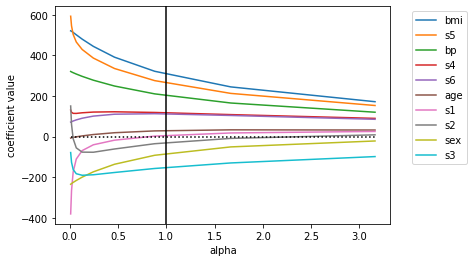

In [ ]:
ax = inspector.plot_coefs_vs_hparam("alpha", np.logspace(-2, 0.5, 10))

/Users/greg/.pyenv/versions/model_inspector/lib/python3.9/site-packages/waterfall_chart.py:66: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  trans.loc[net_label]= total


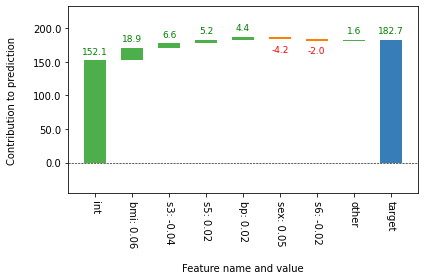

In [ ]:
ax = inspector.plot_waterfall(X.iloc[0])

## Binary Logistic Regression

In [ ]:
#| export
class _LinBinInspector(_BinInspector, _LinInspectorMixin):
    """Linear binary classification model inspector"""

    def plot_coefs_vs_hparam(self, hparam: str, vals: Sequence[float]) -> np.array:
        """Plot coefficient values against a hyperparameter

        Parameters:
        - `hparam`: Name of hyperparameter; must be an attribute of
        `self.model`
        - `vals`: Values of that hyperparameter to use
        """
        current_val = getattr(self.model, hparam)
        model = clone(self.model)
        setattr(model, hparam, vals[-1])
        column_order = model.fit(self.X, self.y).coef_[0].argsort()[::-1]
        X = self.X.iloc[:, column_order]

        coef_arrays = []
        for val in vals:
            setattr(model, hparam, val)
            coef_arrays.append(model.fit(X, self.y).coef_)

        fig, ax = plt.subplots()
        ax.plot(vals, [coefs[0] for coefs in coef_arrays])
        ax.plot([vals.min(), vals.max()], [0, 0], linestyle="dotted", c="k")
        ax.set(xlabel=hparam, ylabel="Coefficient Value")
        ax.axvline(current_val, c="k", label="current value")
        ax.legend(X.columns, bbox_to_anchor=(1.05, 1.0), loc="upper left")
        return ax

    def show_model(
        self,
        intercept_formatter: str = ".2f",
        coef_formatter: str = ".2f",
    ):
        """Show model equation

        Parameters:
        - `intercept_formatter`: Intercept format specifier
        - `coef_formatter`: Intercept format specifier
        """
        return HTML(
            self._generate_model_html(
                intercept=self.model.intercept_[0],
                coefs=self.model.coef_[0],
                target_name=f"log-odds({self.y.name})",
                intercept_formatter=intercept_formatter,
                coef_formatter=coef_formatter,
            )
        )

    @delegates(waterfall_chart.plot)
    def plot_waterfall(
        self,
        item: Union[pd.Series, np.array],
        bar_num_formatter: str = ".1f",
        tick_num_formatter: str = ".2f",
        sorted_value=True,
        threshold=0.01,
        blue_color=COLORS["blue"],
        green_color=COLORS["green"],
        red_color=COLORS["orange"],
        **kwargs,
    ):
        """Make a waterfall chart showing how each feature contributes
        to the prediction for the input item for a binary classification
        model.

        Parameters:
        - `item`: Input item, with the same shape and value meanings as
        a single row from `self.X`
        - `bar_num_formatter`: Bar label format specifier
        - `tick_num_formatter`: Tick label format specifier
        - ``waterfall_kwargs`: kwargs to pass to `waterfall_chart.plot`
        """
        return self._plot_waterfall(
            item=item,
            intercept=self.model.intercept_[0],
            coefs=self.model.coef_[0],
            y_lab="Contribution to predicted log-odds",
            bar_num_formatter=bar_num_formatter,
            tick_num_formatter=tick_num_formatter,
            sorted_value=sorted_value,
            threshold=threshold,
            blue_color=blue_color,
            green_color=green_color,
            red_color=red_color,
            **kwargs,
        )

In [ ]:
from sklearn.linear_model import LogisticRegression

X, y = sklearn.datasets.load_breast_cancer(return_X_y=True, as_frame=True)
X = X.iloc[:, :10]

inspector = get_inspector(LogisticRegression(max_iter=1_000).fit(X, y), X, y)
inspector.show_model()

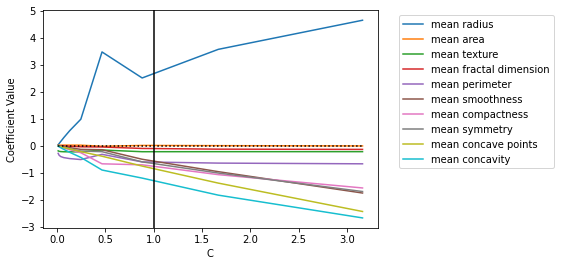

In [ ]:
ax = inspector.plot_coefs_vs_hparam("C", np.logspace(-2, 0.5, 10))

/Users/greg/.pyenv/versions/model_inspector/lib/python3.9/site-packages/waterfall_chart.py:66: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  trans.loc[net_label]= total


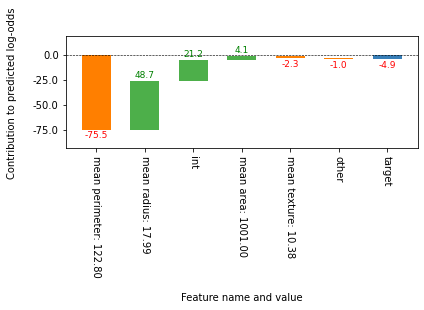

In [ ]:
ax = inspector.plot_waterfall(X.iloc[0])

## Multiclass Logistic Regression

In [ ]:
#| export
class _LinMultiInspector(_MultiInspector, _LinInspectorMixin):
    """Linear multiclass classification model inspector"""

    def plot_coefs_vs_hparam(self, hparam: str, vals: Sequence[float]) -> np.array:
        """Plot coefficient values against a hyperparameter

        Parameters:
        - `hparam`: Name of hyperparameter; must be an attribute of
        `self.model`
        - `vals`: Values of that hyperparameter to use
        """
        current_val = getattr(self.model, hparam)
        model = clone(self.model)
        setattr(model, hparam, vals[-1])
        column_order = model.fit(self.X, self.y).coef_[0].argsort()[::-1]
        X = self.X.iloc[:, column_order]

        coef_arrays = []
        for val in vals:
            setattr(model, hparam, val)
            coef_arrays.append(model.fit(X, self.y).coef_)

        num_target_vals = len(set(self.y))

        fig, axes = plt.subplots(
            num_target_vals, 1, sharex=True, sharey=True, constrained_layout=True
        )
        for target_val_num in range(num_target_vals):
            axes[target_val_num].plot(
                vals, [coefs[target_val_num] for coefs in coef_arrays]
            )
            axes[target_val_num].set_title(f"y={sorted(set(self.y))[target_val_num]}")
        axes[0].set(xlabel=hparam, ylabel="Coefficient Value")
        for ax in axes:
            ax.axvline(current_val, c="k", label="current value")
            ax.plot([vals.min(), vals.max()], [0, 0], linestyle="dotted", c="k")
        axes[0].legend(X.columns, bbox_to_anchor=(1.05, 1.0), loc="upper left")
        return axes

    def show_model(
        self,
        intercept_formatter: str = ".2f",
        coef_formatter: str = ".2f",
    ):
        """Show model equation

        Parameters:
        - `intercept_formatter`: Intercept format specifier
        - `coef_formatter`: Intercept format specifier
        """
        model_string = ""
        for target_name, coefs, intercept in zip(
            np.unique(self.y), self.model.coef_, self.model.intercept_
        ):
            model_string += f"""
                    <p>
                        {self._generate_model_html(
                                intercept=intercept,
                                coefs=coefs,
                                target_name=f"log-odds({self.y.name} = {target_name})",
                                intercept_formatter=intercept_formatter,
                                coef_formatter=coef_formatter,
                            )
                        }
                    </p>
                """
        return HTML(model_string)

In [ ]:
from sklearn.linear_model import LogisticRegression

X, y = sklearn.datasets.load_iris(return_X_y=True, as_frame=True)

inspector = get_inspector(LogisticRegression(max_iter=10_000).fit(X, y), X, y)
inspector.show_model()

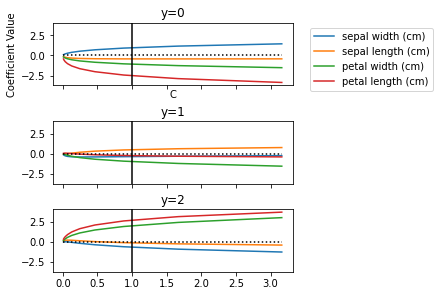

In [ ]:
ax = inspector.plot_coefs_vs_hparam("C", np.logspace(-2, 0.5, 10))

In [ ]:
#| export
_all_ = ["_LinRegInspector", "_LinBinInspector", "_LinMultiInspector"]